# Embeddings and RAG

In this notebook we will learn what an embedding and how it can be used in retrieval, later to augment LLM generation.

In [1]:
!pip install -q sentence_transformers transformers hf_transfer torch plotly scipy tqdm matplotlib pandas

import os

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


An embeding is a vector representation of a piece of information. The information can be a word (token), a paragraph, an image, etc.  
The vector resides in a high-dimensional space, named the ***embedding space*** or ***latent space***.

<br>

The model that generates the embedding is called an encoder. You can find many example of encoders such as:
- the embedding layer of an LLM, which takes a token and converts it into a vector the model can understand.
- a model that can take many text tokens and convert them into a vector encoding the meaning of the text.
- a model that can take an image and convert it into a vector represntation of the image.

---

We will be using [`stella`](https://huggingface.co/dunzhang/stella_en_1.5B_v5) as a test model.
Stella is an encoder model capable of generating an embedding from up to 512 tokens.

We will be using the first layer of `stella` to visualize and undetstand 1 token embeddings, and the entire model to understand multi-token embeddings.

`sentence_transformers` will be the library used to load the model and generate embeddings.


In [2]:
from sentence_transformers import SentenceTransformer
import torch

with torch.no_grad():
    model = SentenceTransformer(
        "dunzhang/stella_en_1.5B_v5",
        trust_remote_code=True,
        device="cuda",
        model_kwargs={
            "torch_dtype": torch.float16,
            # "load_in_8bit": True,
        },
    )   


## Let's understand embeddings

For simplicity, we will be using pure 1 token embeddings. They are mostly a 1-to-1 mapping between a work and the representation of that word in the embedding space.  

We will be using the first layer of the model, and working with the input embedding space.

In [3]:
token_to_internal_embedding_weights = next(model[0].named_parameters())[1]

In [4]:
words = ["bird", "woman", "man", "person"]
tokens = [model.tokenizer.vocab[x] for x in words]
for word, token in zip(words, tokens):
    print(f"{word} token:", token)

embeddings = token_to_internal_embedding_weights[[token for token in tokens]]
for word, embedding in zip(words, embeddings):
    print(f"{word} embedding:", embedding)

bird token: 22592
woman token: 22028
man token: 1515
person token: 8987
bird embedding: tensor([ 0.0307,  0.0019, -0.0015,  ..., -0.0216,  0.0342,  0.0062],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
woman embedding: tensor([-0.0081,  0.0173, -0.0048,  ...,  0.0002, -0.0101,  0.0237],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
man embedding: tensor([-0.0140, -0.0220, -0.0115,  ..., -0.0002,  0.0038,  0.0136],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
person embedding: tensor([ 0.0046,  0.0035,  0.0173,  ..., -0.0100,  0.0056, -0.0030],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)


What can we do with this embedding vector?

The vectors depresent a direction from the point of origin, which means that if we have 2 vectors, we can compare their distance using a few metrics:
- the cosine distance / cosine similarity
- the euclidean distance
- the manhattan distance

---

The most common metric is the cosine similarity, which is the angle between the two vectors inside the latent space.  

The cosine similarity is calculated by:
1. Normalizing both vectors (dividing by their magnitude/length)
2. Taking the dot product of the normalized vectors
 
This gives us a value between -1 and 1:
- 1 means the vectors point in exactly the same direction (very similar)
- 0 means the vectors are perpendicular (unrelated)
- -1 means the vectors point in opposite directions (very dissimilar)

Let's encode a few words and compare their distance.

In [5]:
def cosine_similarity(v1, v2):
    # Normalize vectors
    v1_normalized = v1 / torch.norm(v1)
    v2_normalized = v2 / torch.norm(v2)

    # Compute cosine similarity (dot product of normalized vectors)
    similarity = torch.dot(v1_normalized, v2_normalized)

    return similarity.item()

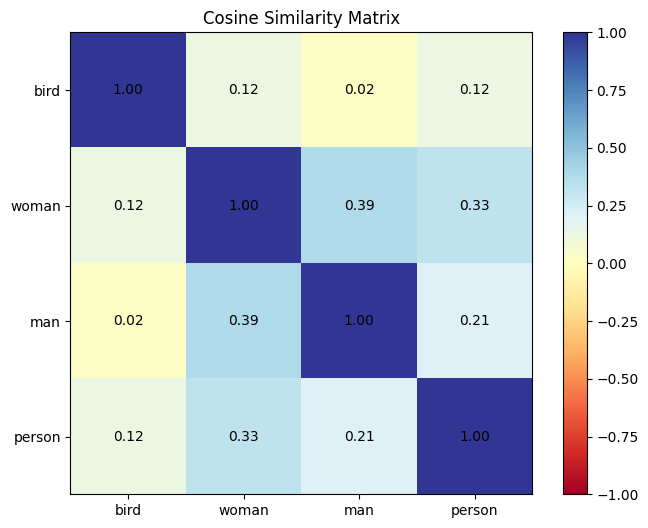

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate similarity matrix
similarity_matrix = torch.zeros((len(words), len(words)))

for i in range(len(words)):
    for j in range(len(words)):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Create heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap="RdYlBu", vmin=-1, vmax=1)

# Add labels
plt.xticks(range(len(words)), words)
plt.yticks(range(len(words)), words)

# Add colorbar
plt.colorbar()

# Add values in cells
for i in range(len(words)):
    for j in range(len(words)):
        plt.text(j, i, f"{similarity_matrix[i,j]:.2f}", ha="center", va="center")

plt.title("Cosine Similarity Matrix")
plt.show()


## Embedding vectors arithmetic

Since we're working with vectors, we can do vector arithmetic to navigate the latent space.



Firstly, let's reduce the dimensionality of the embedding space to 2D, so we can visualize it.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=128)
input_embeddings_2d = pca.fit_transform(
    token_to_internal_embedding_weights.detach().cpu().numpy()
)

Pick a few words and plot them in the 2D space.

In [8]:
man_embedding = input_embeddings_2d[model.tokenizer.vocab["man"]]
king_embedding = input_embeddings_2d[model.tokenizer.vocab["king"]]

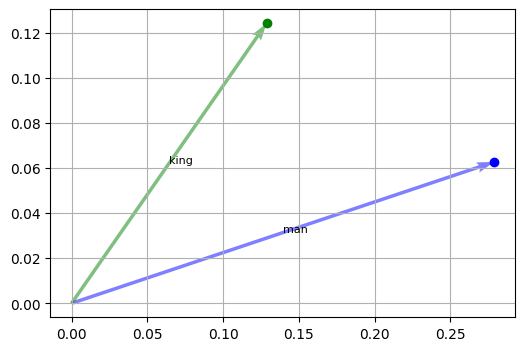

In [9]:
import matplotlib.pyplot as plt


def visualize_vectors(embeddings, labels, colors):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    for i, ((x0, y0, x1, y1), label, color) in enumerate(
        zip(embeddings, labels, colors)
    ):
        # Draw arrow from origin to point in 2D
        ax.quiver(
            x0,
            y0,
            x1,
            y1,
            color=color,
            angles="xy",
            scale_units="xy",
            scale=1,
            alpha=0.5,
        )
        # Add scatter point and label
        ax.scatter(x0 + x1, y0 + y1, c=color, label=label)
        ax.text(x0 + x1 / 2, y0 + y1 / 2, label, size=8)
    plt.grid(True)
    plt.show()


visualize_vectors(
    [np.pad(man_embedding, (2, 0)), np.pad(king_embedding, (2, 0))],
    ["man", "king"],
    ["blue", "green"],
)

Now, let's visualize the direction of royalty.

We will subtract the man embedding from the king embedding to get the direction of the royalty concept.

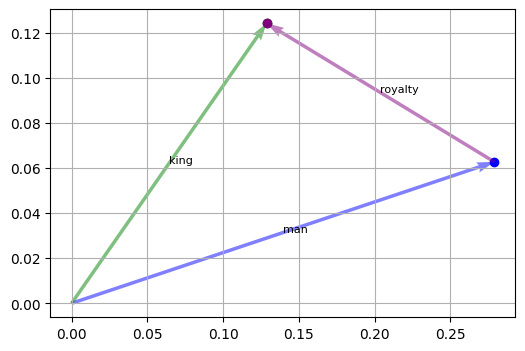

In [10]:
royalty_direction = king_embedding - man_embedding

visualize_vectors(
    [
        np.pad(man_embedding, (2, 0)),
        np.pad(king_embedding, (2, 0)),
        np.concatenate((man_embedding, royalty_direction)),
    ],
    ["man", "king", "royalty"],
    ["blue", "green", "purple"],
)


Now let's add royalty to the `woman` embedding.

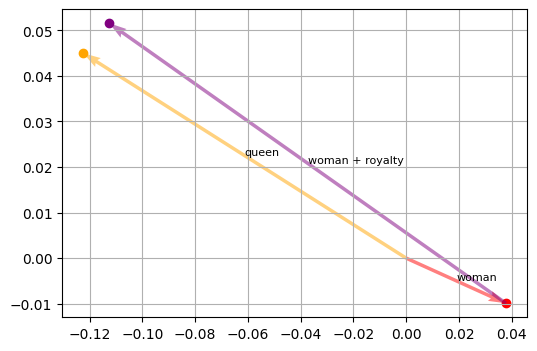

In [11]:
woman_embedding = input_embeddings_2d[model.tokenizer.vocab["woman"]]
queen_embedding = input_embeddings_2d[model.tokenizer.vocab["queen"]]

woman_plus_royalty = woman_embedding + royalty_direction

visualize_vectors(
    [
        np.pad(woman_embedding, (2, 0)),
        np.pad(queen_embedding, (2, 0)),
        np.concatenate((woman_embedding, royalty_direction)),
    ],
    ["woman", "queen", "woman + royalty"],
    ["red", "orange", "purple"],
)

And to view all the vectors in the same plot, we can do the following:

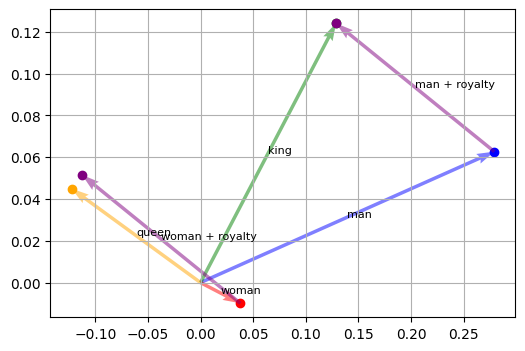

In [12]:
visualize_vectors(
    [
        np.pad(man_embedding, (2, 0)),
        np.pad(woman_embedding, (2, 0)),
        np.pad(king_embedding, (2, 0)),
        np.pad(queen_embedding, (2, 0)),
        np.concatenate((man_embedding, royalty_direction)),
        np.concatenate((woman_embedding, royalty_direction)),
    ],
    ["man", "woman", "king", "queen", "man + royalty", "woman + royalty"],
    ["blue", "red", "green", "orange", "purple", "purple"],
)

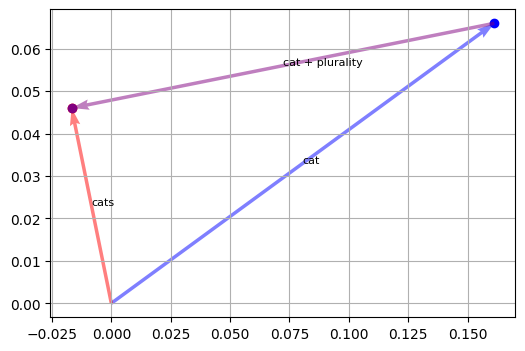

In [13]:
cat_embedding = input_embeddings_2d[model.tokenizer.vocab["cat"]]
cats_embedding = input_embeddings_2d[model.tokenizer.vocab["cats"]]

plurality_direction = cats_embedding - cat_embedding

visualize_vectors(
    [
        np.pad(cat_embedding, (2, 0)),
        np.pad(cats_embedding, (2, 0)),
        np.concatenate((cat_embedding, plurality_direction)),
    ],
    ["cat", "cats", "cat + plurality"],
    ["blue", "red", "purple"],
)


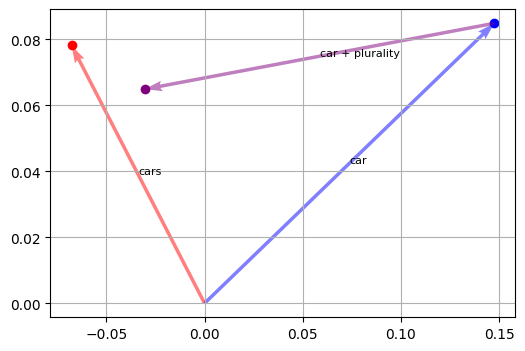

In [14]:
car_embedding = input_embeddings_2d[model.tokenizer.vocab["car"]]
cars_embedding = input_embeddings_2d[model.tokenizer.vocab["cars"]]

car_plus_plurality = car_embedding + plurality_direction

visualize_vectors(
    [
        np.pad(car_embedding, (2, 0)),
        np.pad(cars_embedding, (2, 0)),
        np.concatenate((car_embedding, plurality_direction)),
    ],
    ["car", "cars", "car + plurality"],
    ["blue", "red", "purple"],
)

## Embedding more than 1 token

Let's have a look at the results of encoding a few sentences with the model.

Previously we have played with toy examples of embeddings generated by the first layer of the model, taking a token mapping it to the input embedding space.

The different between the previouse approach and this one is that we will now be encoding an entire sequence of tokens, each token having it's own vector flowing through the model's network, until the final layer, where they are all combined into a single vector.  

---

| Embedding a single token | Embedding a sequence of tokens |
|-------------------------|-------------------------------|
| <img src="../.images/embedding-input-layer.png" width="500" valign="top"> | <img src="../.images/embedding-model.png" width="500" valign="top"> |

---

**Important Notes:** 
- The latent space of a layer (e.g. the first layer) is not the same as the latent space of the model. Each layer generates a different latent space encoding different information.
- The latent space of a model is not the same as the latent space of another model. Results from different encoders (even if having the same dimension) cannot be compared.


In [15]:
paragraphs = [
    # why the sky is blue
    "The sky appears blue due to a phenomenon called Rayleigh scattering. "
    "When sunlight travels through the Earth's atmosphere, it collides with gas molecules. "
    "These molecules scatter the light in all directions, but they scatter shorter wavelengths (blue light) more strongly than longer wavelengths (red light). "
    "This scattered blue light reaches our eyes from all directions in the sky, making it appear blue.",
    # health benefits of green tea
    "Green tea offers numerous health benefits due to its high concentration of antioxidants and beneficial compounds. "
    "Regular consumption has been linked to improved brain function, fat loss, protection against cancer, and reduced risk of heart disease. "
    "The tea contains bioactive compounds like polyphenols that can reduce inflammation and help prevent cell damage. "
    "It also contains caffeine and L-theanine, which can improve mood and cognitive performance.",
    # how an electric engine works
    "An electric engine, or electric motor, converts electrical energy into mechanical energy through electromagnetic interaction. "
    "It consists of a stator (stationary part) and a rotor (rotating part) that work together using magnetic fields created by electrical current. "
    "When electricity flows through wire coils in the motor, it creates magnetic fields that cause the rotor to spin. "
    "This mechanical rotation can then power various devices, from small appliances to large electric vehicles.",
    # how a combustion engine works
    "A combustion engine converts chemical energy from fuel into mechanical energy through controlled explosions. "
    "The engine uses pistons inside cylinders that move up and down through four main strokes: intake, compression, combustion, and exhaust. "
    "During combustion, fuel mixed with air is ignited by spark plugs, creating explosive force that drives the pistons. "
    "This reciprocating motion is converted to rotary motion by the crankshaft to power vehicles and other machines.",
]

paragraph_labels = ["Sky", "Green Tea", "Electric Engine", "Combustion Engine"]

# Encode each paragraph
encoded_paragraphs = model.encode(paragraphs)


Using the cosine similarity metric, let's see how similar are the paragraphs with each other.

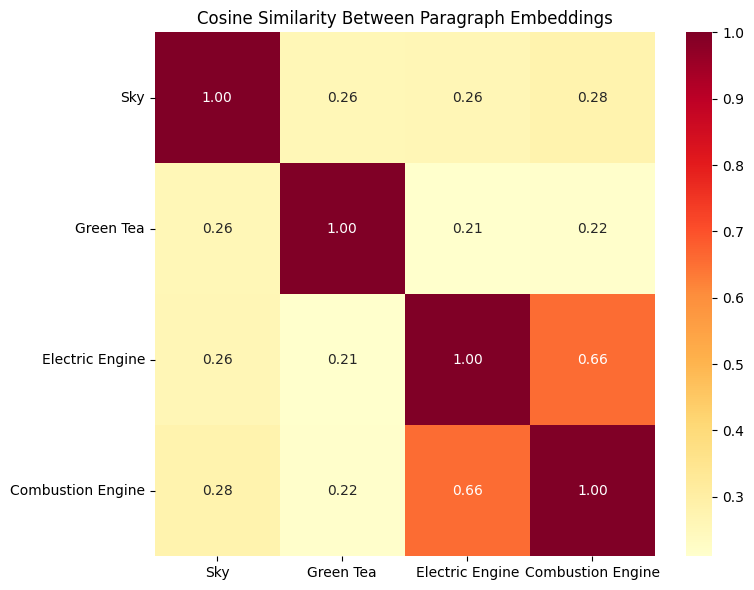

In [16]:
# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(encoded_paragraphs)

# Create heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="YlOrRd",
    xticklabels=paragraph_labels,
    yticklabels=paragraph_labels,
    fmt=".2f",
)
plt.title("Cosine Similarity Between Paragraph Embeddings")
plt.tight_layout()
plt.show()


As you can see, the paragraphs taking about engines have a higher similarity score with each other then the other paragraphs which are cloner to the score of being unrelated.

## Generating embeddings to find similar documents

Some models, like `stella`, can generate embeddings for short questions, that have a high similarity score with documents that tend to answer the question.

This model supports to such queries:
- s2p_query: sequence to paragraph query.  
  This is an instruction that will generate an embedding from a question which is very close to answering documents.  
  `"Instruct: Given a web search query, retrieve relevant passages that answer the query.\nQuery: {text}"`  
  
- s2s_query: sequence to sequence query.  
  This is an instruction that will generate an embedding looking for semantically similar documents.  
  `"Instruct: Retrieve semantically similar text.\nQuery: {text}"`  

Let's see how this works.



In [17]:
queries = [
    "why is the sky blue?",
    "what's up with green tea?",
    "Why is green tea good for you?",
    "how does an engine work?",
    "how does an electric engine work?",
    "how does a combustion engine work?",
]
query_embeddings = model.encode(queries, prompt_name="s2p_query")

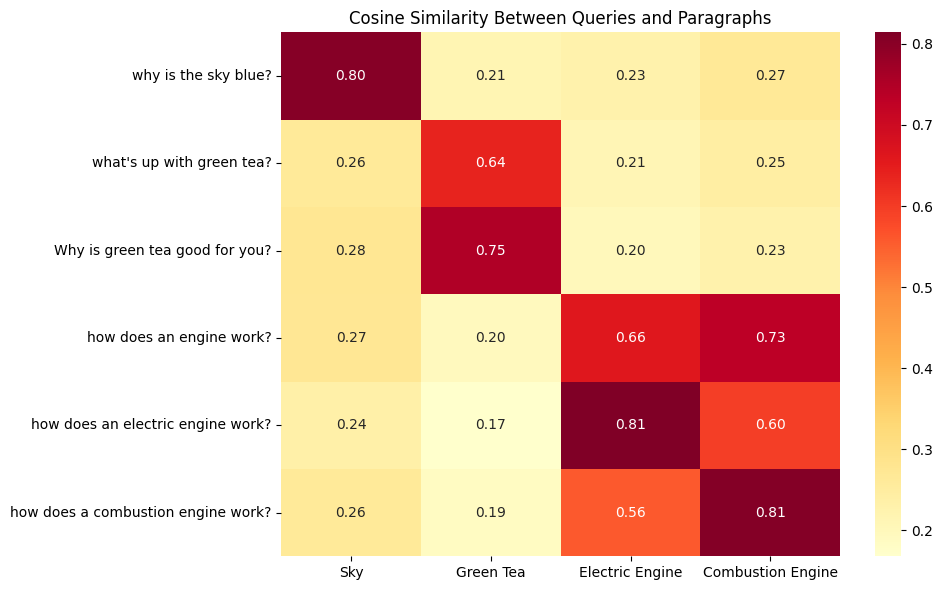

In [18]:
# Calculate cosine similarity between queries and paragraphs
similarity_matrix = cosine_similarity(query_embeddings, encoded_paragraphs)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="YlOrRd",
    xticklabels=paragraph_labels,
    yticklabels=queries,
    fmt=".2f",
)
plt.title("Cosine Similarity Between Queries and Paragraphs")
plt.tight_layout()
plt.show()


| Query | Observation |
|-------|-------------|
| "why is the sky blue?" | Very similar to the sky paragraph, unrelated to other paragraphs |
| "what's up with green tea?" | Very similar to green tea paragraph |
| "Why is green tea good for you?" | Very similar to green tea paragraph, with higher similarity than general query |
| "how does an engine work?" | Closely matches both engine paragraphs, shows higher similarity to combustion engines reflecting common terminology |
| "how does an electric engine work?" | Matches both engine paragraphs, but shows stronger similarity to the electric engine paragraph |
| "how does a combustion engine work?" | Matches both engine paragraphs, but shows stronger similarity to the combustion engine paragraph |


## Chunking documents

Because an embedding is a vector representation of a piece of information, it can only reliably represent a single concentrated concept or idea.  
The more information you add to the embedding, the less focused it becomes. 

Chunking is a very important step. It allows us to split a document into smaller chunks, each hopefully representing a single concept or idea.  

Here is an example of overcrowded documents.  
The last 2 documents are very similar to each other, except that the first one has electric engines at the end, and the second one has electric engines at the beginning.  
Those two documents have too much information, which dilutes their focus.

In [19]:
paragraphs_overcrowded = [
    # history of electric engine invention
    "The electric engine was pioneered by multiple inventors in the 1800s, with major breakthroughs by Michael Faraday. "
    "In 1821, Faraday demonstrated electromagnetic rotation, creating the first crude electric motor by showing that a current-carrying conductor would rotate around a permanent magnet. "
    "This discovery laid the foundation for practical electric motors. Throughout the 1800s, inventors like Thomas Davenport, who patented the first electric motor in 1837, and Werner von Siemens, who developed the first practical DC motor in 1866, made important improvements. "
    "These early innovations led to the development of modern electric motors that power everything from small devices to large industrial machinery.",
    
    # how a combustion engine works
    "A combustion engine converts chemical energy from fuel into mechanical energy through controlled explosions. "
    "The engine uses pistons inside cylinders that move up and down through four main strokes: intake, compression, combustion, and exhaust. "
    "During combustion, fuel mixed with air is ignited by spark plugs, creating explosive force that drives the pistons. "
    "This reciprocating motion is converted to rotary motion by the crankshaft to power vehicles and other machines.",
    
    # What is green tea? + why is the sky blue? + how does an electric engine work?
    "Green tea is a type of tea made from unoxidized leaves of the Camellia sinensis plant. "
    "The processing of green tea is minimal - the fresh leaves are quickly heated by pan firing or steaming to prevent oxidation, then dried. "
    "This preserves the natural green color and results in a tea with a light, fresh flavor profile. "
    "Green tea contains beneficial compounds like catechins, particularly EGCG (epigallocatechin gallate), which are powerful antioxidants. "
    "The caffeine content in green tea is lower than coffee or black tea, typically ranging from 12-75 mg per cup. "
    "When brewing green tea, water temperature should be around 160-180°F (70-82°C) to avoid bitterness. "
    "Different varieties of green tea exist, including popular types like Sencha from Japan and Dragon Well (Longjing) from China, each with distinct characteristics based on growing conditions and processing methods. "
    #
    "The sky appears blue due to a phenomenon called Rayleigh scattering. "
    "When sunlight travels through Earth's atmosphere, it collides with gas molecules. "
    "These molecules scatter the light in all directions, but they scatter shorter wavelengths (blue light) more strongly than longer wavelengths (red light). "
    "When we look at the sky, we see this scattered blue light coming from all directions. "
    "This is why the sky appears blue during most of the day. "
    "During sunrise and sunset, sunlight travels through more atmosphere to reach our eyes, causing more blue light to be scattered away. "
    "This leaves more red and orange light, which is why the sky often appears these colors at dawn and dusk. "
    "The intensity of the blue color can vary depending on atmospheric conditions like humidity, pollution, and the angle of the sun. "
    #
    "An electric engine, also known as an electric motor, operates through electromagnetic principles. "
    "The key components are the stator (stationary outer part) containing electromagnets or permanent magnets, and the rotor (rotating inner part) with copper wire windings. "
    "When electric current flows through the copper windings, it creates a magnetic field. This magnetic field interacts with the magnetic field from the stator. "
    "The interaction between these magnetic fields creates a rotational force (torque) that causes the rotor to spin. "
    "By continuously changing the direction of current flow through the windings using commutators (in DC motors) or electronic controllers (in AC motors), "
    "the motor maintains continuous rotation. The speed and power of the motor can be precisely controlled by adjusting the current flow. ",
]

paragraphs_overcrowded_labels = [
    "History of Electric Engine",
    "How a Combustion Engine Works",
    "green tea + blue sky + how electric engines work",
]

encoded_paragraphs_overcrowded = model.encode(paragraphs_overcrowded)

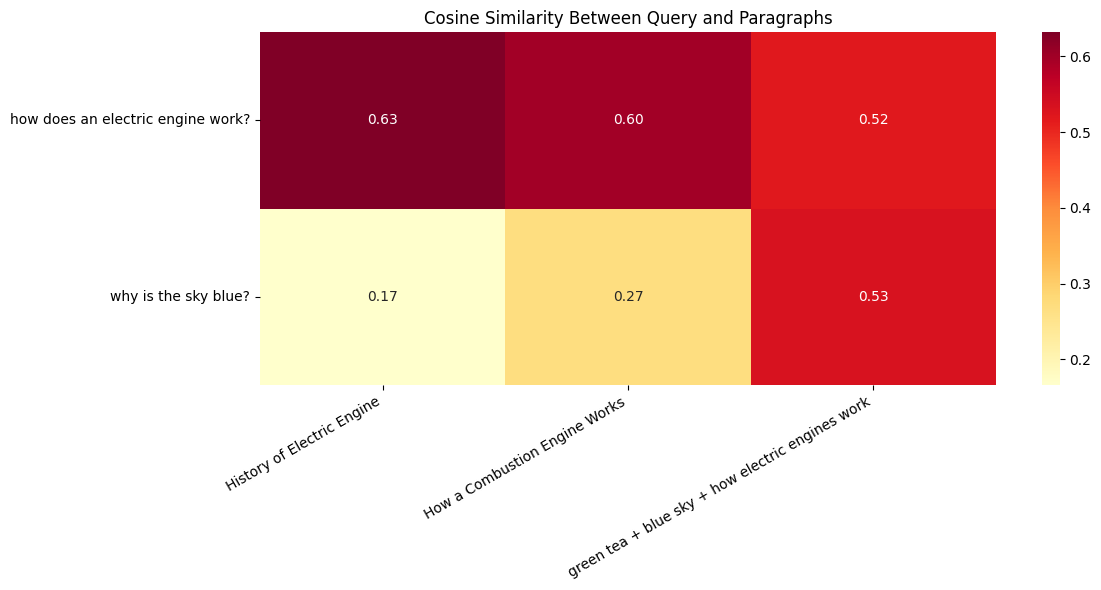

In [20]:
more_queries = [
    "how does an electric engine work?",
    "why is the sky blue?",
]

query_embedding = model.encode(more_queries, prompt_name="s2p_query")
similarity_matrix = cosine_similarity(query_embedding, encoded_paragraphs_overcrowded)

plt.figure(figsize=(12, 6))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="YlOrRd",
    xticklabels=paragraphs_overcrowded_labels,
    yticklabels=more_queries,
    fmt=".2f",
)
plt.title("Cosine Similarity Between Query and Paragraphs")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We will be using the [`chonkie`](https://github.com/chonkie-ai/chonkie) library to chunk the documents.

There are multiple types of chunking, here are some simple examples:
- max tokens: chunk the document into chunks of a maximum number of tokens
- max tokens with overlap: chunk the document into chunks of a maximum number of tokens, with a specified overlap between chunks
- sentences: chunk the document into chunks of a maximum number of sentences

We will be using a various set of chunkers to chunk the document.

In [21]:
!pip install -q chonkie[semantic,st]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Chunking method: WordChunker(chunk_size=256, chunk_overlap=128)
Chunking time: 0.01s
Chunk 0:
Green tea is a type of tea made from unoxidized leaves of the Camellia sinensis plant
The processing of green tea is minimal - the fresh leaves are quickly heated by pan firing or steaming to prevent oxidation, then dried
This preserves the natural green color and results in a tea with a light, fresh flavor profile
Green tea contains beneficial compounds like catechins, particularly EGCG (epigallocatechin gallate), which are powerful antioxidants
The caffeine content in green tea is lower than coffee or black tea, typically ranging from 12-75 mg per cup
When brewing green tea, water temperature should be around 160-180°F (70-82°C) to avoid bitterness
Different varieties of green tea exist, including popular types like Sencha from Japan and Dragon Well (Longjing) from China, each with distinct characteristics based on growing conditions and processing methods
The sky appears blue due to a pheno

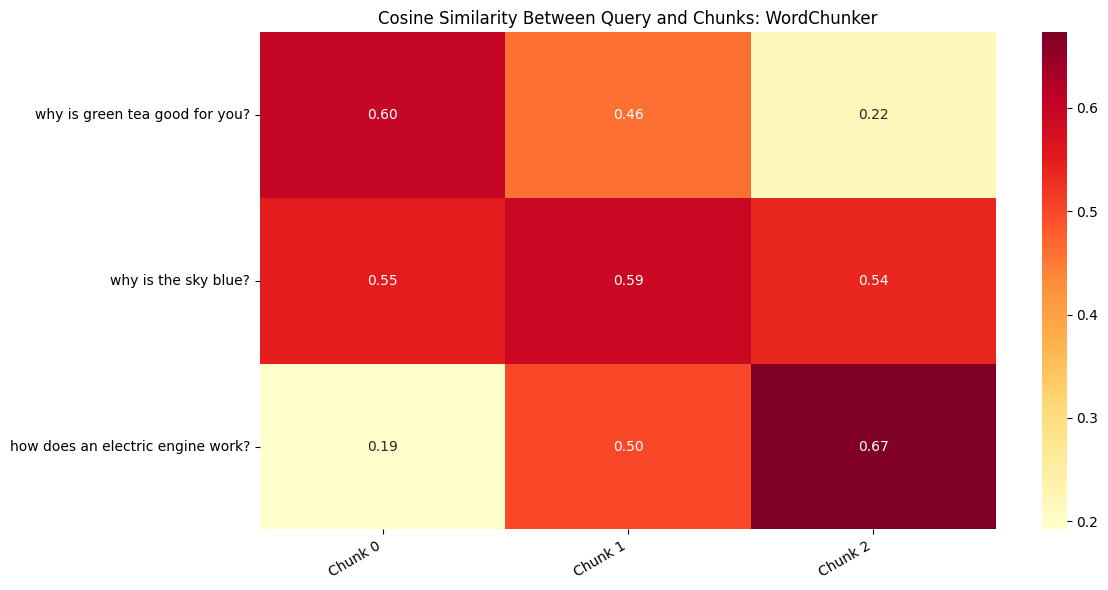

Chunking method: SentenceChunker(chunk_size=256, chunk_overlap=32, min_sentences_per_chunk=1)
Chunking time: 0.00s
Chunk 0:
Green tea is a type of tea made from unoxidized leaves of the Camellia sinensis plant
The processing of green tea is minimal - the fresh leaves are quickly heated by pan firing or steaming to prevent oxidation, then dried
This preserves the natural green color and results in a tea with a light, fresh flavor profile
Green tea contains beneficial compounds like catechins, particularly EGCG (epigallocatechin gallate), which are powerful antioxidants
The caffeine content in green tea is lower than coffee or black tea, typically ranging from 12-75 mg per cup
When brewing green tea, water temperature should be around 160-180°F (70-82°C) to avoid bitterness
Different varieties of green tea exist, including popular types like Sencha from Japan and Dragon Well (Longjing) from China, each with distinct characteristics based on growing conditions and processing methods
The s

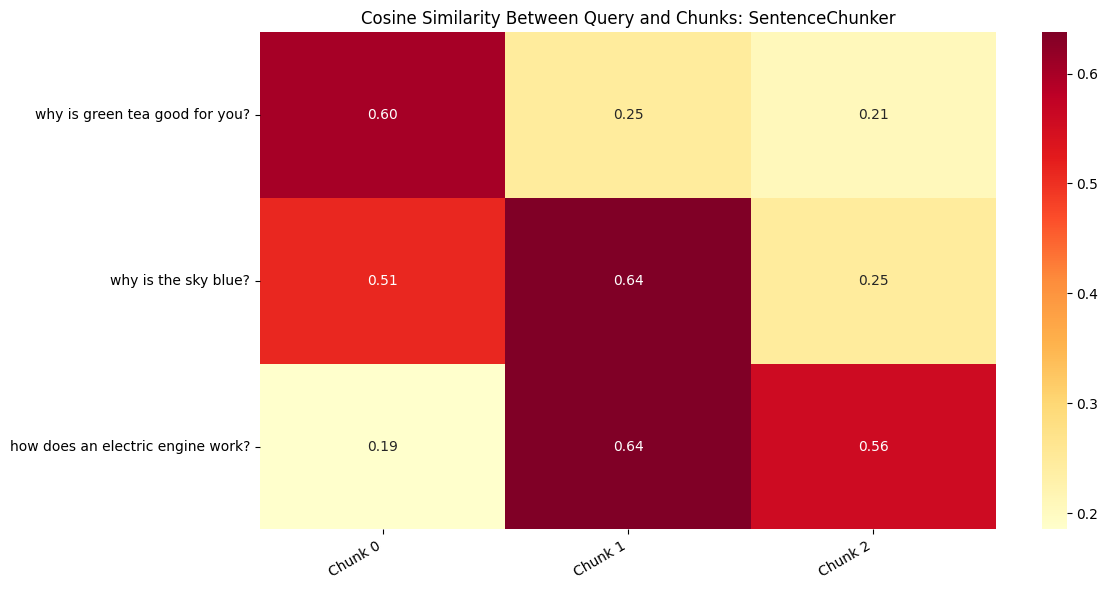

Chunking method: SPDMChunker(embedding_model=Model2VecEmbeddings(model_name_or_path=minishlab/potion-base-8M), mode=window, threshold=auto, chunk_size=256, similarity_window=1, min_sentences=1, min_chunk_size=2, min_characters_per_sentence=12, threshold_step=0.01, skip_window=1)
Chunking time: 0.00s
Chunk 0:
Green tea is a type of tea made from unoxidized leaves of the Camellia sinensis plant
The processing of green tea is minimal - the fresh leaves are quickly heated by pan firing or steaming to prevent oxidation, then dried
This preserves the natural green color and results in a tea with a light, fresh flavor profile
Green tea contains beneficial compounds like catechins, particularly EGCG (epigallocatechin gallate), which are powerful antioxidants
The caffeine content in green tea is lower than coffee or black tea, typically ranging from 12-75 mg per cup
When brewing green tea, water temperature should be around 160-180°F (70-82°C) to avoid bitterness
Different varieties of green te

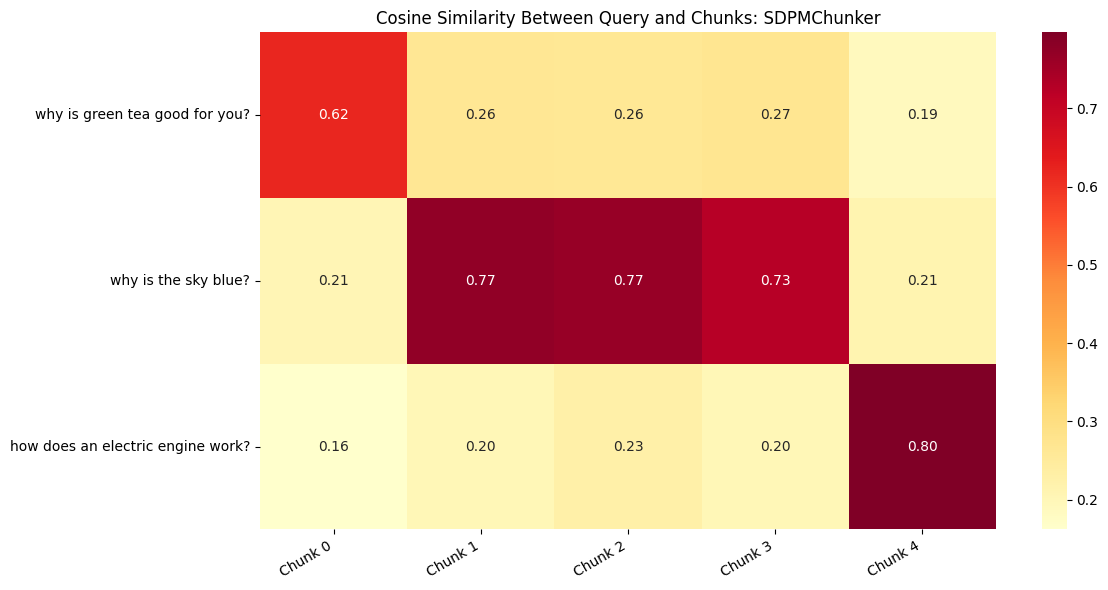

In [22]:
from time import time
from chonkie import SDPMChunker, SentenceChunker, WordChunker 

more_queries = [
    "why is green tea good for you?",
    "why is the sky blue?",
    "how does an electric engine work?",
]
query_embedding = model.encode(more_queries, prompt_name="s2p_query")

# chunk the last big document with different chunking methods
for chunk_method in [
    WordChunker(chunk_size=256),
    SentenceChunker(chunk_size=256, chunk_overlap=32),
    SDPMChunker(chunk_size=256),
]:
    print(f"Chunking method: {chunk_method}")

    start = time()
    chunks = [str(c) for c in chunk_method.chunk(paragraphs_overcrowded[-1])]
    end = time()
    print(f"Chunking time: {end - start:.2f}s")

    if isinstance(chunk_method, SDPMChunker):
        # there's a bug in chunky. it add the first sencente of chunk I to chunk I-1
        for i in range(len(chunks) - 1):
            sentences = chunks[i].split('. ')
            chunks[i] = '. '.join(sentences[:-1])
            chunks[i + 1] = sentences[-1] + ". " + chunks[i + 1]
        chunks = [c.strip() for c in chunks if c.strip() != ""]

    NL = "\n"
    for i, c in enumerate(chunks):
        print(f"Chunk {i}:\n{NL.join(c.split('. '))}", end=NL * 2)

    chunk_embeds = model.encode(chunks)

    similarity_matrix = cosine_similarity(query_embedding, chunk_embeds)

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        cmap="YlOrRd",
        xticklabels=[f"Chunk {i}" for i in range(len(chunks))],
        yticklabels=more_queries,
        fmt=".2f",
    )
    plt.title(
        f"Cosine Similarity Between Query and Chunks: {chunk_method.__class__.__name__}"
    )
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# todo
- load embedding model in int8, see what breaks

- find some financial data
- chunk it
- embed it
- add to qdrant vector database in memory
- load a LLM that can do function calling (maybe gemini flash?)
- add function to query the vector DB
- generate the answer

optional
- make llm restructure the question before querying the vector DB

In [23]:
!pip install -q PyPDF2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
if not os.path.exists("biology-textbook.pdf"):
    !curl -o "biology-textbook.pdf" -L "https://d3bxy9euw4e147.cloudfront.net/oscms-prodcms/media/documents/Biology2e-OP_aHSFm3Y.pdf"

In [25]:
from PyPDF2 import PdfReader
from tqdm import tqdm
reader = PdfReader("biology-textbook.pdf")

all_text = ""
# start from page 19, because the first 19 pages are index and not part of the book
# end at page 1518, because that's the last page of the book, next are questions and index
for page in tqdm(reader.pages[19:1518]):
    all_text += page.extract_text() + '\n'

# cleanup
all_text = all_text.replace('This OpenStax book is available for free at http://cnx.org/content/col24361/1.8', ' ')

100%|██████████| 1499/1499 [00:11<00:00, 125.25it/s]


In [26]:
chunker = SDPMChunker(chunk_size=256)
biology_chunks = [str(c) for c in chunker.chunk(all_text)]

len(biology_chunks)

13774

In [27]:
biology_embeddings = model.encode(biology_chunks)
# fix nan chunks
biology_embeddings = np.array([e for e in biology_embeddings if not np.isnan(e).any()])
biology_embeddings.shape

(13754, 1024)

In [28]:
query = "rna editing"
query = "flower pollination"
query = "paleontology"
query_embedding = model.encode(query, prompt_name="s2p_query")

In [29]:
top_k = torch.tensor(cosine_similarity([query_embedding], biology_embeddings)).topk(k=15)
top_k_indices = top_k.indices.squeeze().tolist()
top_k_values = top_k.values.squeeze().tolist()

for i, value in zip(top_k_indices, top_k_values):
    print(f"Chunk {i}: {value:.2f}")
    print(biology_chunks[i])
    print()


Chunk 6755: 0.72
explosive diversification of dinosaurs into every conceivable niche in land, air, and water. Plants, too, radiated


Chunk 122: 0.70
20 Researchers work on excavating dinosaur fossils at a site in Castellón, Spain. (credit: Mario Modesto)
Paleontology , another branch of biology, uses fossils to study life’s history (Figure 1.20 ).Zoology andbotany
are the study of animals and plants, respectively.

Chunk 5924: 0.64
 One of the richest sources of information is the Rhynie chert, a sedimentary rock deposit found in
Rhynie, Scotland (Figure 25.5 ), where embedded fossils of some of the earliest vascular plants have been
identified.
Figure 25.5 Early vascular plant fossils. This Rhynie chert (a) contains fossilized material from vascular plants.
Reconstruction of Cooksonia (b), the plant forms inside the circle. (credit b: modification of work by Peter Coxhead


Chunk 5925: 0.60
based on original image by “Smith609”/Wikimedia Commons; scale-bar data from Matt Russell)


C

# todo add gemini flash 2.0 for function calling